# Introduction

## Capstone Project Submission

***
- Name: Adam Marianacci
- Scheduled project review date/time: 3/19/2024/1:30pm EST

# Business Understanding

It is my task to help companies with computer vision for their A.I. tennis ball machines.

# Data Understanding

I created all the data used in this project. I used roughly 6,000 images that consisted of a balanced class of forehand and backhand tennis shots. 
The limitations of the dataset was that it was a fairly small set of data. The images used only consisted of myself hitting forehand and backhand tennis shots. The data used for this project was useful to build a convolutional neural network for image classification because their was a minimal amount of variance in the data used. The neural net was able to learn specific patterns about forehands and backhands with minimal "noise" in the data because of the consistency of the data used.

Dataset:[ForehandsandBackhands](https://www.kaggle.com/datasets/adammarianacci/forehands-and-backhands)


# Data Preparation

   I started by filming myself in a few different locations hitting approximately 200 forehands and 200 backhands. I then used an open source editing program called "Shotcut" to edit all of my swings from the start of my swing up until the point of contact with the tennis ball. I then converted these edited video shots into an mp4 format so that they could be extracted into frames. One shot clip yieled roughly 15 images of data.
    I extracted the frames into folders and labeled the frames as either belonging to one of two classes "1" for forehand and "0" for backhand. I constructed an iterator into my pipeline to be able to call on specific "batches" of data. I then scaled my data in the pipeline to make sure that all the images used were the same size.
    I then set up a train, test, split which was 80% for training, 10% for validation, and 10% for testing. I then set up a way to save and load my data after it has been trained into my pipeline so that more data could be input in the future.

For reproducibility I uploaded my data to Kaggle and tested my notebook in Google Colab to ensure my notebook would run smoothly. If you wish to access the data and run this notebook on another platform such as Google Colab you will have to have a Kaggle account. 
- In the cell below you will have to enter your Kaggle username and API Key.
This [creating token](https://stackoverflow.com/a/71674371) link will help give you instructions on how to obtain an API key.
- This [link](https://www.kaggle.com/docs/api) is also helpful for more information on how to use Kaggle

Uncomment the cell below if you wish to work from another notebook

In [1]:
# import json 
# import os
# from pathlib import Path

# # please enter your Kaggle username and api key here
# username = ''
# key = ''

# # your api key
# api_key = {
# 'username': username,
# 'key': key}

# # uses pathlib Path
# kaggle_path = Path('/root/.kaggle')
# os.makedirs(kaggle_path, exist_ok=True)

# # opens file and dumps python dict to json object 
# with open (kaggle_path/'kaggle.json', 'w') as handl:
#     json.dump(api_key,handl)

# os.chmod(kaggle_path/'kaggle.json', 600)  


Uncomment the cell below if you would like to download the data.

In [2]:
# This downloads the images for training and testing
# !kaggle datasets download -d adammarianacci/forehands-and-backhands
# !unzip forehands-and-backhands.zip

In [3]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imghdr
import os
import PIL
import tensorflow as tf
import pickle
import hashlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

The cell below enables you to select videos within a specified folder. The function enables you to extract frames from the video file and puts them into a specified folder within the directory. It iterates thru all video files ending with' mp4' and 'avi' and saves the the extracted frames into a specified folder. If you wish to use this function uncomment the cell beloew and use your own file paths for the 'video_directory' and 'output directory' 

In [4]:
# # Directory containing the video files
# video_directory = '/home/adam/Desktop/video_test'

# # Output directory for extracted frames
# output_directory = '/home/adam/Desktop/frame_test'

# # Function to extract frames from a video file
# def extract_frames(video_file, output_dir):
#     # Open the video file
#     vid = cv2.VideoCapture(video_file)
#     if not vid.isOpened():
#         print(f"Error: Couldn't open video file '{video_file}'")
#         return

#     # Create output directory if it doesn't exist
#     os.makedirs(output_dir, exist_ok=True)

#     # Initialize frame counter
#     current_frame = 0

#     # Read frames and save them as images
#     while True:
#         success, frame = vid.read()

#         if not success:
#             print(f"End of video reached or couldn't read frame from '{video_file}'")
#             break

#         if frame.shape[0] > 0 and frame.shape[1] > 0:
#             # Save the frame as an image
#             output_path = os.path.join(output_dir, f'{os.path.splitext(os.path.basename(video_file))[0]}_{current_frame}.jpg')
#             cv2.imwrite(output_path, frame)
#             current_frame += 1
#         else:
#             print(f"Error: Invalid frame size in '{video_file}'")

#     vid.release()

# # Iterate over video files in the directory
# for video_file in os.listdir(video_directory):
#     if video_file.endswith('.mp4') or video_file.endswith('.avi'):
#         video_path = os.path.join(video_directory, video_file)
#         extract_frames(video_path, output_directory)

In [5]:
# Defining a data directory
data_dir = 'data'

The cell below sets up a variable to recognize different images types.

In [6]:
# Defining image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

The cell below shows that my data directory contains my 2 classes.

In [7]:
# Checking the contents of my data directory
os.listdir(data_dir)

['forehands', 'backhands']

The cell below sets up a for loop that goes thru the folders and all images in the data directory and removes any images that does not have the appropriate image extensions. Note the skipping output is just skipping directories but there are no issues with the actual files in the directories.

In [8]:
# Iterate through directories containing images
for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_dir):
        continue  # Skip if not a directory
    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image)
        if not os.path.isfile(image_path):
            print('Skipping non-file:', image_path)
            continue  # Skip if not a file
        try:
            tip = imghdr.what(image_path)  # Get image type directly
            if tip is None or tip not in image_exts:
                print('Image not in ext list or invalid format: {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}: {}'.format(image_path, str(e)))
            # Log the error or handle it appropriately

Skipping non-file: data/forehands/vids
Skipping non-file: data/forehands/frames
Skipping non-file: data/backhands/vids
Skipping non-file: data/backhands/frames


Here we start to preprocess the data, we are starting with approx. 6,000 images belonging to two classes that are balanced. This sets up the data pipleline and enables access to "batches" of data using the iterator.

In [9]:
# loading in tensorflow and keras on our data 
data = tf.keras.preprocessing.image_dataset_from_directory('data')

Found 6325 files belonging to 2 classes.


In [10]:
# allow acces to generator from the data pipeline
data_iterator = data.as_numpy_iterator()

In [11]:
# allow access to pull a batch (32 images) of data
batch = data_iterator.next()

batch size of 32, image size of 256x256, 3 (channels of color, RGB)

In [12]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [13]:
# representing the labels in the batch
batch[1]

array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1], dtype=int32)

Below I am plotting some images from a batch to see which classes my images belong to and we can see Forehands = 1 and Backhands = 0.

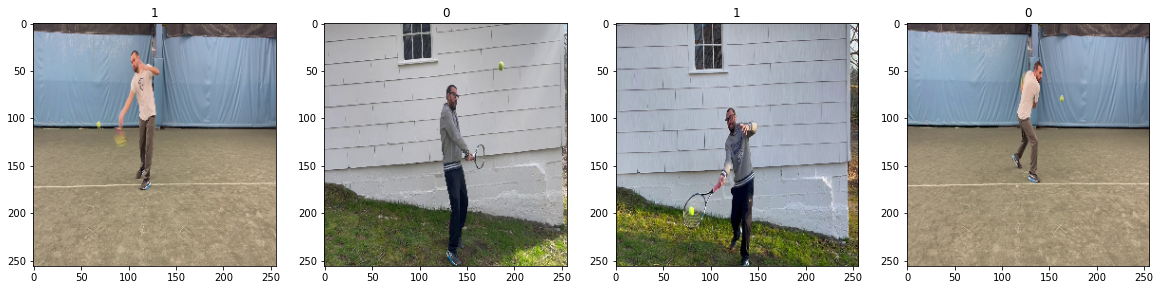

In [14]:
# viewing some  data to see what class my frames belong to
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

The below cell transforms the images "X" to all be scaled for optimization in the data pipeline. I typed in .map function using lambda in google and found this [solution](https://stackoverflow.com/questions/48234088/mapping-arrays-in-python-using-map-lambda-and-functional-programming-workflows)

In [15]:
# scaling data in the pipeline
data = data.map(lambda X,y: (X/255, y))

In [16]:
# The iterator is now scaled from 0 to 1
scaled_iterator = data.as_numpy_iterator()

In [17]:
# renaming the variable batch so that it will always be scaled
batch = scaled_iterator.next()

In [18]:
# confirming the min is 0
batch[0].min()

0.0

In [19]:
# confirming max is 1
batch[0].max()

1.0

Here we are visualizing another batch of data to make sure everything is working on the scaled data.

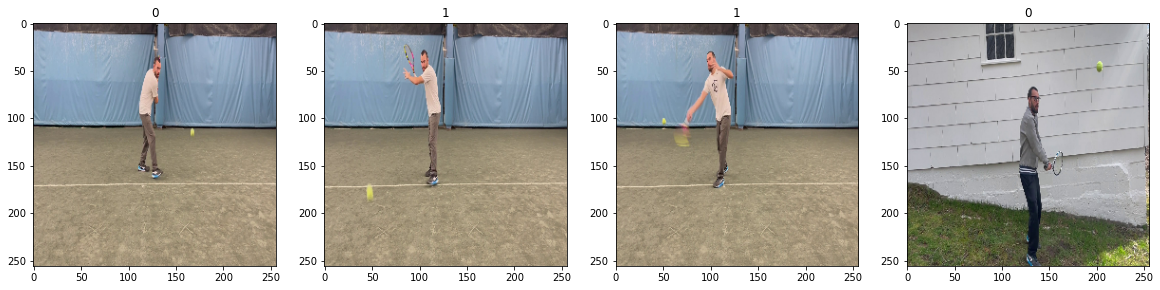

In [20]:
# viewing a batch of data to see what class my frames belong to
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Here I am ready to start my train, test, split. I check the length of the data (in batches) and we see we have 89 batches

In [21]:
# Checking the length of the data in batches
len(data) 

198

I shuffled the data so that when I eventually use it for modeling it is not biased by learning about the images in any particular order.

In [22]:
# Shuffle the dataset
data_shuffled = data.shuffle(buffer_size=len(data))

This splits that data for training, testing, and validation by the number by batches. I designated 80% to training which is 158 batches, 10% testing which is 15 batches, and 10% for validation which is 15 batches.

In [23]:
# Splitting data into 80% training, 10% testing, 10% validation
train_size = int(len(data_shuffled)*.8)
val_size = int(len(data_shuffled)*.1)+1
test_size = int(len(data_shuffled)*.1)+1

Confirming the splits equal to 198 batches.

In [24]:
# 198 batches
train_size+val_size+test_size

198

The cell below now sets up the variables to either take or skip certain batches.

In [25]:
train = data_shuffled.take(train_size)
val = data_shuffled.skip(train_size).take(val_size)
test = data_shuffled.skip(train_size + val_size).take(test_size)

# Modeling

In [26]:
model = Sequential()

The first layer is a convolutional layer with 16 filters, it is 3 pixels x 3pixels, and a stride of 1 so it goes pixel by pixel. The relu activation function takes into account any non linear patterns. The input shape is the size of our images. The next 2 layers are condensing the rows and width. The last 2 layers are dense fully connected layers and a sigmoid activation function is applied for the output to be between 0 and 1. An output of closer to 1 will be part of the forehand class, and an output of 0 will be closer to the Backhand class.

In [27]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

The cell below passes through an optomizer, and BinaryCrossentropy to our loss because we are dealing with Binary Classification, and the metrics we are going to be evaluating on will be accuracy.

In [28]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

The cell below shows how the model takes in the data.

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

In [30]:
# Creating a log directory that is my logs folder
logdir = 'logs'

The cell below creates a variable 'tensorboard_callback' which allows you to log the model training while it trains.

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

The cell below sets up the training process at 20 epochs for the baseline model. It will also be evaluating on our validation data as well. The below cell is commented out to save time as it takes around 45 minutes to run. The model was quickly overfitting after a few epochs so to save time I adjusted the model to 3 epochs which is currently our best performing model. This also saves the model as an h5 file in the specified folder 'models'

In [32]:
# This line of code will initiate training, it will take approx 45 minutes
#hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
# model.save(os.path.join('models', 'forehandbackhandmodel_20.h5'))

In [33]:
# This line of code will initiate training, it will take approx 15 minutes
hist = model.fit(train, epochs=2, validation_data=val, callbacks=[tensorboard_callback])
#model.save(os.path.join('models', 'forehandbackhandmodel_2.h5'))

Epoch 1/2
  1/158 [..............................] - ETA: 0s - loss: 0.6993 - accuracy: 0.4688WARNING:tensorflow:From /home/adam/anaconda3/envs/learn-env-1/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
158/158 [==============================] - 153s 968ms/step - loss: 0.0747 - accuracy: 0.9691 - val_loss: 7.4142e-04 - val_accuracy: 1.0000
Epoch 2/2
158/158 [==============================] - 155s 983ms/step - loss: 7.8431e-05 - accuracy: 1.0000 - val_loss: 1.3813e-05 - val_accuracy: 1.0000


Plotting the performance which led to 100% accuracy and a decreasing loss close that dropped close to 0.

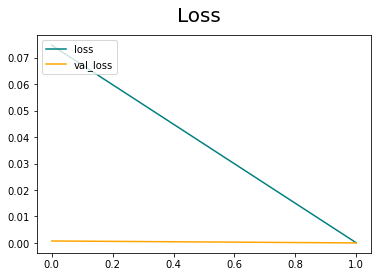

In [34]:
# Visualizing our loss

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

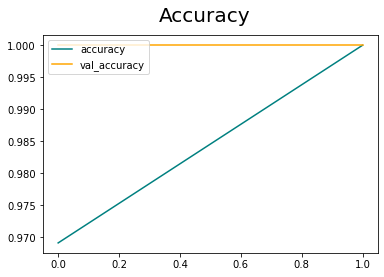

In [35]:
# Visualizing our accuracy

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

After we have trained on our model on training and validation data and have visualized the loss and metrics of accuracy we can see how it performs on testing images. 

In [36]:
# loading in a newly trained model to evaluate on testing images
#new_model = load_model(os.path.join('models', 'forehandbackhandmodel_3.h5'))

Evaluating performance on our testing data

In [37]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    y_hat = model.predict(X)
    precision.update_state(y, y_hat)
    recall.update_state(y, y_hat)
    accuracy.update_state(y, y_hat)

Our testing data is performing at 100% accuracy.

In [ ]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()},  Accuracy:{accuracy.result().numpy()}')

In [ ]:
# Performing a test on an image not in our batch
img = cv2.imread('data/backhands/frames/backhandvids_1004.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

Predicting on a random image the model has never seen before. This preprocesses an image an image array and feeds it into the NN 'model' and returns a prediction probability score.

In [ ]:
y_hat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
# It is predicting what our image is 
y_hat

The cell below is a conditional statement that prints out what the predicted class is. We are taking the probability score of 'y_hat' which is our target class prediction and setting a threshold of 0.5. If the probability score is greather than 0.5 the predicted class will be a forehand and if it is less than 0.5 the predicted class will be a backhand.

In [ ]:
if y_hat > 0.5:
    print(f'Predddicted class is Forehand')
else:
    print(f'Predicted class is Backhand')

# Model Evaluation

My best performing model was the CNN with an 'Adam' optomizer and loss function set to 'Binary Cross-Entropy' trained over 3 epochs. I adjusted the model from 20 epochs to 3 because the model was quickly acheiving a 100% accuracy score so this approximately saved about 1 hour of training time. The model was showing 100% accuracy scores on training and testing data. The model is most likely overfitting due to the low variance in my data making it over confident.

# Conclusions

The model showed scores of 100% on accuracy, precision, and recall. The model is performing perfectly most likely due to the low variance in my dataset leading to it's overconfidence. To build a more robust model 10x more data with high variance needs to be inputted into to the model.

## Limitations

Limited amount of data was used. The data consisted only of myself from one camera angle in a few different locations with minimal background "noise". Additionally the model only learned about two-handed backhand shots and not one-handed backhand shots.

## Recommendations

We need to increase the amount of variance in the dataset. Since the current model is performing so well we can start to add images from the start of swing preparation until the completion of the swing and not just up until the point of contact with the ball.

## Next Steps

Obtain more 10x more data with more variance of different people of all ages hitting shots from different camera angles in different backgrounds. The real world is "noisier" so we need to start training our model this way.